# Prediction Alignment: From Sequences to Aligned Predictions

Complete workflow from generating variant sequences to running model predictions and aligning them for comparison. Core functionality for analyzing how genetic variants affect model predictions.

## What You'll Learn

- Generate reference and alternate sequences around variants
- Run mock genomic models (1D and 2D predictions)
- Align predictions to account for coordinate changes from variants
- Visualize prediction differences between reference and alternate alleles

## The Complete Workflow

```
Reference Genome + VCF
        ↓
get_alt_ref_sequences()
        ↓
Reference & Alternate Sequences
        ↓
TestModel / TestModel2D
        ↓
Reference & Alternate Predictions
        ↓
align_predictions_by_coordinate()
        ↓
Aligned Predictions (ready for comparison!)
```

## Setup

## Setup

:::{tip}
**Check out the [Prediction Alignment Examples](../user_guide/prediction_alignment_examples.md) page for illustrated diagrams showing how alignment works for each variant type (INS, DEL, DUP, INV, BND) with both 1D and 2D predictions.
:::

In [1]:
import supremo_lite as sl
from supremo_lite.mock_models import TestModel, TestModel2D, TORCH_AVAILABLE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyfaidx import Fasta
import os

# Set plotting style
sns.set_style("whitegrid")

# Check PyTorch availability
if not TORCH_AVAILABLE:
    raise ImportError(
        "PyTorch is required for this notebook. Install with: pip install torch"
    )

print(f"supremo_lite version: {sl.__version__}")
print(f"PyTorch available: {TORCH_AVAILABLE}")

# Load test data
test_data_dir = "../../tests/data"
reference = Fasta(os.path.join(test_data_dir, "test_genome.fa"))
variants = sl.read_vcf(os.path.join(test_data_dir, "multi", "multi.vcf"))

print(f"\nLoaded {len(variants)} variants from test data")

supremo_lite version: 0.5.5
PyTorch available: True

Loaded 8 variants from test data


## Step 1: Generate Reference and Alternate Sequences

First, we create sequence windows around each variant:

In [2]:
# Generate sequences around first variant
# We'll use a 30bp window (sufficient for our mock models)
seq_len = 30

# Note: get_alt_ref_sequences is a generator that yields chunks
results = list(
    sl.get_alt_ref_sequences(
        reference_fn=reference,
        variants_fn=variants,
        seq_len=seq_len,
        encode=True,  # Get encoded tensors for models
    )
)

# Unpack from the first chunk
alt_seqs, ref_seqs, metadata = results[0]

print(f"Generated sequences:")
print(f"  Reference sequences shape: {ref_seqs.shape}")
print(f"  Alternate sequences shape: {alt_seqs.shape}")
print(f"  Number of variants: {len(metadata)}")

print("\nDEL variant metadata:")
print(metadata.iloc[2].to_dict())

Generated sequences:
  Reference sequences shape: torch.Size([8, 4, 30])
  Alternate sequences shape: torch.Size([8, 4, 30])
  Number of variants: 8

DEL variant metadata:
{'chrom': 'chr1', 'window_start': 0, 'window_end': 30, 'variant_pos0': 10, 'variant_pos1': 11, 'ref': 'TATTTTCGAGAAT', 'alt': 'T', 'variant_type': 'DEL'}


## Understanding Mock Models

Before running predictions, let's understand the mock model architectures:

### TestModel (1D Predictions)
- **Input**: Sequences of shape `(batch, 4, seq_len)` - channel-first format
- **Output**: Predictions of shape `(batch, n_targets, n_bins)`
- **Features**:
  - `bin_length`: Predictions at lower resolution (e.g., 1 prediction per 2bp)
  - `crop_length`: Edge bases removed before prediction
  - Multiple targets (e.g., different histone marks)

### TestModel2D (2D Contact Map Predictions)
- **Input**: Sequences of shape `(batch, 4, seq_len)` - channel-first format
- **Output**: Predictions of shape `(batch, n_targets, n_bins, n_bins)`
- **Features**:
  - Contact predictions between genomic positions (full matrix)
  - `bin_length` and `crop_length` like 1D model
  - Returns full symmetric contact matrix

**Note**: Sequences are automatically encoded in channel-first format `(batch, 4, seq_len)`, which is compatible with PyTorch Conv1d layers without requiring `.permute()` operations.

## Step 2: Run 1D Predictions with TestModel

In [3]:
# Initialize 1D model
model_1d = TestModel(
    seq_length=seq_len,
    n_targets=1,  # Predict 1 signal
    bin_length=2,  # 1 prediction per 2bp
    crop_length=2,  # Remove 2bp from each edge
)

print("TestModel (1D) configuration:")
print(f"  Targets: {model_1d.n_targets}")
print(f"  Bin size: {model_1d.bin_length}")
print(f"  Crop length: {model_1d.crop_length}")
print(f"  Input sequence length: {seq_len}")
print(f"  Effective sequence length: {seq_len - 2*model_1d.crop_length}")
print(f"  Number of bins: {(seq_len - 2*model_1d.crop_length) // model_1d.bin_length}")

# Sequences are already in (batch, 4, seq_len) format - no permute needed!
print(f"\nInput shapes (already channel-first):")
print(f"  Reference: {ref_seqs.shape}")
print(f"  Alternate: {alt_seqs.shape}")

# Run predictions
ref_preds_1d = model_1d(ref_seqs)
alt_preds_1d = model_1d(alt_seqs)

print(f"\nPrediction shapes:")
print(f"  Reference: {ref_preds_1d.shape}")
print(f"  Alternate: {alt_preds_1d.shape}")
print(
    f"  Format: (batch={ref_preds_1d.shape[0]}, targets={ref_preds_1d.shape[1]}, bins={ref_preds_1d.shape[2]})"
)

TestModel (1D) configuration:
  Targets: 1
  Bin size: 2
  Crop length: 2
  Input sequence length: 30
  Effective sequence length: 26
  Number of bins: 13

Input shapes (already channel-first):
  Reference: torch.Size([8, 4, 30])
  Alternate: torch.Size([8, 4, 30])

Prediction shapes:
  Reference: torch.Size([8, 1, 13])
  Alternate: torch.Size([8, 1, 13])
  Format: (batch=8, targets=1, bins=13)


## Step 3: Align 1D Predictions

Now we align the predictions to account for coordinate changes caused by the variant:

In [ ]:
# Align predictions
var_idx = 2

ref_aligned_1d, alt_aligned_1d = sl.align_predictions_by_coordinate(
    ref_preds=ref_preds_1d[var_idx],
    alt_preds=alt_preds_1d[var_idx],
    metadata_row=metadata.iloc[var_idx].to_dict(),
    prediction_type="1D",
    bin_size=model_1d.bin_length,
    crop_length=2,
)

print(f"Aligned prediction shapes:")
print(f"  Reference aligned: {ref_aligned_1d.shape}")
print(f"  Alternate aligned: {alt_aligned_1d.shape}")

print(f"\nVariant info:")
print(f"  Type: {metadata.iloc[var_idx]['variant_type']}")
print(f"  {metadata.iloc[var_idx]['ref']} → {metadata.iloc[var_idx]['alt']}")
print(
    f"  Position: {metadata.iloc[var_idx]['chrom']}:{metadata.iloc[var_idx]['variant_pos1']}"
)

## Visualizing 1D Aligned Predictions

Let's visualize how the predictions compare:

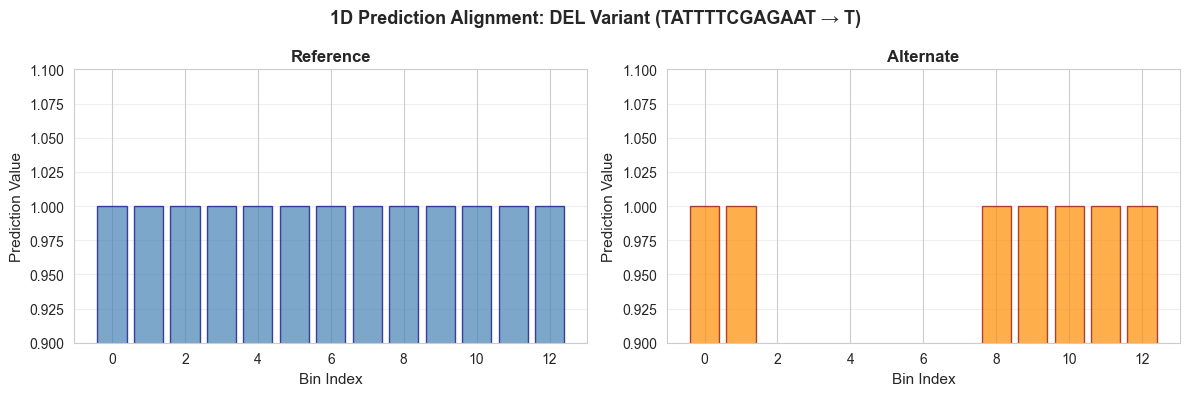


Interpretation:
• Left: Reference allele predictions (blue bars) - all 20 bins present
• Right: Alternate allele predictions (orange bars) - notice the GAP
• The missing bars in the alternate plot represent the deletion
  - Bins 2-7 are masked (NaN values) because the sequence was deleted
  - This maintains coordinate alignment between reference and alternate
• With real models, you would see prediction changes around the deletion


In [24]:
# Convert to numpy for plotting
ref_1d_np = (
    ref_aligned_1d.cpu().numpy() if hasattr(ref_aligned_1d, "cpu") else ref_aligned_1d
)
alt_1d_np = (
    alt_aligned_1d.cpu().numpy() if hasattr(alt_aligned_1d, "cpu") else alt_aligned_1d
)

# Create figure with two panels: ref and alt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Calculate bin positions (integer indices)
bin_indices = np.arange(len(ref_1d_np[0]))

# Reference predictions
ax_ref = axes[0]
ax_ref.bar(bin_indices, ref_1d_np[0], color="steelblue", alpha=0.7, edgecolor="navy")
ax_ref.set_xlabel("Bin Index", fontsize=11)
ax_ref.set_ylabel("Prediction Value", fontsize=11)
ax_ref.set_title("Reference", fontsize=12, fontweight="bold")
ax_ref.grid(True, alpha=0.3, axis="y")
ax_ref.set_xticks(bin_indices[::2])  # Show every other tick to avoid crowding

# Alternate predictions
ax_alt = axes[1]
ax_alt.bar(
    bin_indices, alt_1d_np[0], color="darkorange", alpha=0.7, edgecolor="darkred"
)
ax_alt.set_xlabel("Bin Index", fontsize=11)
ax_alt.set_ylabel("Prediction Value", fontsize=11)
ax_alt.set_title("Alternate", fontsize=12, fontweight="bold")
ax_alt.grid(True, alpha=0.3, axis="y")
ax_alt.set_xticks(bin_indices[::2])  # Show every other tick to avoid crowding

# Add annotation pointing to the gap where deletion occurred
masked_bins = np.isnan(alt_1d_np[0])
if np.any(masked_bins):
    masked_indices = bin_indices[masked_bins]
    gap_start = masked_indices[0]
    gap_end = masked_indices[-1]
    gap_center = (gap_start + gap_end) / 2

    ax_alt.annotate(
        f"Deletion masked\n(bins {gap_start}-{gap_end})",
        xy=(gap_center, 0.5),
        xytext=(gap_center + 3, 0.7),
        fontsize=10,
        fontweight="bold",
        color="red",
        ha="left",
        arrowprops=dict(arrowstyle="->", color="red", lw=2),
    )

# Keep y-axis limits consistent
y_min = np.nanmin([ref_1d_np[0].min(), np.nanmin(alt_1d_np[0])])
y_max = np.nanmax([ref_1d_np[0].max(), np.nanmax(alt_1d_np[0])])
for ax in axes:
    ax.set_ylim([y_min - 0.1, y_max + 0.1])

fig.suptitle(
    f'1D Prediction Alignment: {metadata.iloc[var_idx]["variant_type"]} Variant '
    f'({metadata.iloc[var_idx]["ref"]} → {metadata.iloc[var_idx]["alt"]})',
    fontsize=13,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Left: Reference allele predictions (blue bars) - all 20 bins present")
print("• Right: Alternate allele predictions (orange bars) - notice the GAP")
print("• The missing bars in the alternate plot represent the deletion")
print("  - Bins 2-7 are masked (NaN values) because the sequence was deleted")
print("  - This maintains coordinate alignment between reference and alternate")
print("• With real models, you would see prediction changes around the deletion")

The ratio of the reference and alternative predictions can now be taken while ignoring the bins where the actual sequence was different.

## Step 4: Run 2D Predictions with TestModel2D

Now let's predict contact maps (2D predictions):

In [25]:
# Initialize 2D model
model_2d = TestModel2D(
    seq_length=seq_len,
    n_targets=1,
    bin_length=2,  # 1 prediction per 2bp
    crop_length=2,  # Remove 2bp from each edge
)

n_bins = model_2d.n_final_bins

print("TestModel2D (Contact Map) configuration:")
print(f"  Targets: {model_2d.n_targets}")
print(f"  Bin size: {model_2d.bin_length}")
print(f"  Crop length: {model_2d.crop_length}")
print(f"  Input sequence length: {seq_len}")
print(f"  Number of bins (after cropping): {n_bins}")

# Sequences are already in (batch, 4, seq_len) format - ready for the model!
# Run predictions
ref_preds_2d = model_2d(ref_seqs)
alt_preds_2d = model_2d(alt_seqs)

print(f"\n2D Prediction shapes:")
print(f"  Reference: {ref_preds_2d.shape}")
print(f"  Alternate: {alt_preds_2d.shape}")
print(
    f"  Format: (batch={ref_preds_2d.shape[0]}, targets={ref_preds_2d.shape[1]}, bins={ref_preds_2d.shape[2]}, bins={ref_preds_2d.shape[3]})"
)

TestModel2D (Contact Map) configuration:
  Targets: 1
  Bin size: 2
  Crop length: 2
  Input sequence length: 30
  Number of bins (after cropping): 13

2D Prediction shapes:
  Reference: torch.Size([8, 1, 13, 13])
  Alternate: torch.Size([8, 1, 13, 13])
  Format: (batch=8, targets=1, bins=13, bins=13)


## Step 5: Align 2D Predictions

Aligning 2D contact maps is more complex because variants affect both dimensions:

In [ ]:
# Align 2D predictions for the deletion variant
ref_aligned_2d, alt_aligned_2d = sl.align_predictions_by_coordinate(
    ref_preds=ref_preds_2d[var_idx, 0],  # First target
    alt_preds=alt_preds_2d[var_idx, 0],
    metadata_row=metadata.iloc[var_idx].to_dict(),
    prediction_type="2D",
    bin_size=model_2d.bin_length,
    matrix_size=n_bins,
    crop_length=2,
)

print(f"Aligned 2D prediction shapes:")
print(f"  Reference aligned: {ref_aligned_2d.shape}")
print(f"  Alternate aligned: {alt_aligned_2d.shape}")
print(f"  Format: (n_bins, n_bins) - square matrix")

## Visualizing 2D Aligned Predictions (Contact Maps)

Contact maps show pairwise interactions between genomic positions:

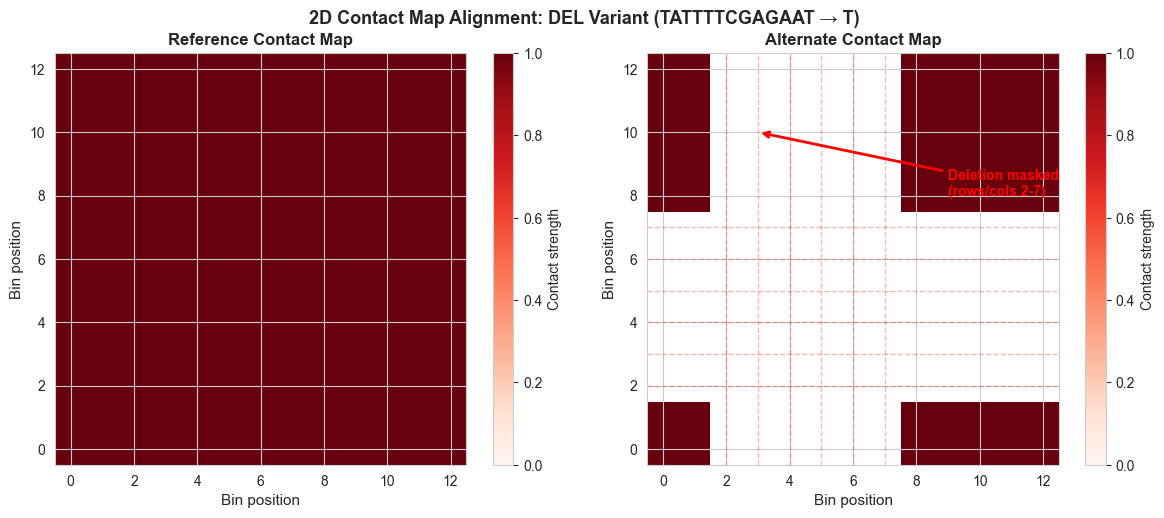


Interpretation:
• Left: Reference allele contact map (all interactions present)
• Right: Alternate allele contact map - notice the cross-pattern of missing data
• The missing rows and columns represent the deletion
  - Rows/columns 2-7 are masked (NaN)
  - 2D masking requires removing entire rows AND columns to maintain coordinate alignment
• With real models, you would see changes in contact patterns around the deletion


In [27]:
# Convert to numpy
ref_2d_np = (
    ref_aligned_2d.cpu().numpy() if hasattr(ref_aligned_2d, "cpu") else ref_aligned_2d
)
alt_2d_np = (
    alt_aligned_2d.cpu().numpy() if hasattr(alt_aligned_2d, "cpu") else alt_aligned_2d
)

# Create figure with two panels: ref and alt
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Reference contact map
im1 = axes[0].imshow(
    ref_2d_np, cmap="Reds", vmin=0, vmax=1, origin="lower", interpolation="nearest"
)
axes[0].set_title("Reference Contact Map", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Bin position", fontsize=11)
axes[0].set_ylabel("Bin position", fontsize=11)
plt.colorbar(im1, ax=axes[0], label="Contact strength")

# Alternate contact map
im2 = axes[1].imshow(
    alt_2d_np, cmap="Reds", vmin=0, vmax=1, origin="lower", interpolation="nearest"
)
axes[1].set_title("Alternate Contact Map", fontsize=12, fontweight="bold")
axes[1].set_xlabel("Bin position", fontsize=11)
axes[1].set_ylabel("Bin position", fontsize=11)
plt.colorbar(im2, ax=axes[1], label="Contact strength")

# Add annotation pointing to masked regions in alternate
# Find masked rows/columns (where entire row or column is NaN)
masked_rows = np.all(np.isnan(alt_2d_np), axis=1)
if np.any(masked_rows):
    masked_indices = np.where(masked_rows)[0]
    gap_start = masked_indices[0]
    gap_end = masked_indices[-1]

    # Add horizontal and vertical lines to show the cross-pattern
    for idx in masked_indices:
        axes[1].axhline(y=idx, color="red", linestyle="--", linewidth=1, alpha=0.3)
        axes[1].axvline(x=idx, color="red", linestyle="--", linewidth=1, alpha=0.3)

    # Add annotation
    axes[1].annotate(
        f"Deletion masked\n(rows/cols {gap_start}-{gap_end})",
        xy=(gap_start + 1, n_bins - 3),
        xytext=(gap_end + 2, n_bins - 5),
        fontsize=10,
        fontweight="bold",
        color="red",
        ha="left",
        arrowprops=dict(arrowstyle="->", color="red", lw=2),
    )

fig.suptitle(
    f'2D Contact Map Alignment: {metadata.iloc[var_idx]["variant_type"]} Variant '
    f'({metadata.iloc[var_idx]["ref"]} → {metadata.iloc[var_idx]["alt"]})',
    fontsize=13,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Left: Reference allele contact map (all interactions present)")
print(
    "• Right: Alternate allele contact map - notice the cross-pattern of missing data"
)
print("• The missing rows and columns represent the deletion")
print(
    f"  - Rows/columns {np.where(masked_rows)[0][0]}-{np.where(masked_rows)[0][-1]} are masked (NaN)"
)
print(
    "  - 2D masking requires removing entire rows AND columns to maintain coordinate alignment"
)
print(
    "• With real models, you would see changes in contact patterns around the deletion"
)

## Key Concepts Summary

### Model Architecture Components

1. **Binning (`bin_length`)**
   - Reduces resolution: 1 prediction per N base pairs
   - Example: `bin_length=2` means 2bp → 1 prediction
   - More efficient than per-base predictions

2. **Edge Cropping (`crop_length`)**
   - Removes bases from sequence edges before prediction
   - Accounts for edge effects in convolutional models
   - Example: `crop_length=1` removes 1bp from each end

### Prediction Alignment

- **Why align?** Indels shift genomic coordinates between ref and alt, and you should only compare predictions for bins where the sequences were the same
- **How?** Mask bins and shift bins to maintain coordinate correspondence
- **1D alignment**: Masks affected bins in the prediction vector
- **2D alignment**: Masks affected rows AND columns (cross-pattern for all indels)

### Output Interpretation

- **Solid lines/values**: Valid predictions at those genomic positions
- **Gaps/NaN**: Regions affected by indels
- **Differences**: Where variant changes model predictions

## Summary

In this notebook, you learned the complete prediction alignment workflow:

1. Generate sequences - Create ref/alt windows around variants
2. 1D predictions - Run TestModel for genomic signal predictions
3. 2D predictions - Run TestModel2D for contact map predictions
4. Align predictions - Account for coordinate changes from variants
5. Visualize results - Compare ref vs alt predictions
6. Understand models - Binning, cropping, diagonal masking concepts

This workflow is the foundation for analyzing how genetic variants affect genomic predictions.